In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

import sys
import os
from pathlib import Path

ROOT = Path.cwd().parent
DATA = ROOT / "data"
sys.path.append(str(ROOT / "functions"))

from categoric_functions import *
from numeric_functions import *

## Import Data

In [2]:
train_path = DATA / "train_merged.csv"
df = pd.read_csv(train_path, low_memory=False)
print(f"Total shape: {df.shape}")

df = df.sort_values('TransactionDT').reset_index(drop=True)
split_idx = int(len(df) * 0.8)

Total shape: (590540, 434)


In [3]:
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

train_df = reduce_mem_usage(train_df.copy())
test_df = reduce_mem_usage(test_df.copy())

Memory usage decreased to 505.96 Mb (67.7% reduction)
Memory usage decreased to 128.29 Mb (67.2% reduction)


# Handling Missing Values

Some features have more than 95% missing values. These are redundat for ml models. I am defining a threshold to determine whether features with missing values will remain in the dataset.

In [4]:
threshold = 95 
high_missing = top_missing_cols(train_df, thresh=threshold)
cols_to_drop = high_missing[high_missing['missing_percent'] > threshold]['col'].tolist()

train_df = train_df.drop(columns=cols_to_drop)
print(f" Threshold : {threshold}%\n Dropped feature num : {len(cols_to_drop)}")

test_df = test_df.drop(columns=[c for c in cols_to_drop if c in test_df.columns])

There are 414 columns with missing values.
There are 9 columns with missing percent > 95%
 Threshold : 95%
 Dropped feature num : 9


### Target

In [5]:
print("Class distribution for 'isFraud':")
print(train_df['isFraud'].value_counts())
print("\nPercentage:")
print(train_df['isFraud'].value_counts(normalize=True))

# counts = train_df['isFraud'].value_counts()
# percentages = train_df['isFraud'].value_counts(normalize=True) * 100

# colors = ['green', 'red'] 
# bars = plt.bar(counts.index, counts.values, color=colors[:len(counts)])

# plt.title('isFraud Class Frequencies')
# plt.xlabel('isFraud')
# plt.ylabel('Count')
# plt.xticks([0, 1])

# for bar, perc in zip(bars, percentages):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, f'{perc:.1f}%', ha='center', va='bottom')

# plt.show()

Class distribution for 'isFraud':
isFraud
0    455833
1     16599
Name: count, dtype: int64

Percentage:
isFraud
0    0.964865
1    0.035135
Name: proportion, dtype: float64


It is known which features are categorical. After cleaning up missing values, the remaining features need to be analysed.

**Categorical features are initially divided into two groups**:
* High cardinality -> 18 features
* Ready for analysis -> 24 features

In [6]:
# =============================================================================
# Feature Type Definitions (Based on Kaggle Competition Description)
# =============================================================================
# These lists are based on the IEEE-CIS Fraud Detection competition data description.
# We will maintain these lists throughout the notebook, updating them as we:
#   - Add new derived features
#   - Remove/transform existing features
#
# Rule: If a feature is NOT in categorical_features, it is considered NUMERICAL.
# =============================================================================

# Original categorical features as defined in the competition
categorical_features = [
    # Transaction features
    'ProductCD',
    # Card features (card1 is high-cardinality ID-like, but categorical)
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    # Address features
    'addr1', 'addr2',
    # Email domains
    'P_emaildomain', 'R_emaildomain',
    # M features (match flags)
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    # Device features
    'DeviceType', 'DeviceInfo',
    # Identity features (categorical)
    'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20',
    'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 
    'id_30',  # OS version string
    'id_31',  # Browser
    'id_32',  # Screen resolution (categorical representation)
    'id_33',  # Screen resolution string (e.g., "1920x1080")
    'id_34', 'id_35', 'id_36', 'id_37', 'id_38'
]

# Keep a copy of the original list for reference
ORIGINAL_CATEGORICAL_FEATURES = categorical_features.copy()

# Filter to only features present in the dataset
present_cat_cols = [col for col in categorical_features if col in train_df.columns]
print(f"Original categorical features defined: {len(ORIGINAL_CATEGORICAL_FEATURES)}")
print(f"Present in dataset after missing value removal: {len(present_cat_cols)}")

# Update categorical_features to only include present columns
categorical_features = present_cat_cols.copy()

# Numerical features = everything else (except target and IDs)
exclude_cols = ['TransactionID', 'TransactionDT', 'isFraud']
numerical_features = [col for col in train_df.columns 
                      if col not in categorical_features and col not in exclude_cols]

print(f"Numerical features: {len(numerical_features)}")
print(f"\nCategorical features will be tracked and updated throughout this notebook.")

Original categorical features defined: 49
Present in dataset after missing value removal: 42
Numerical features: 380

Categorical features will be tracked and updated throughout this notebook.


In [7]:
# Separate categorical features by cardinality for different encoding strategies
cardinality_threshold = 15

low_cardinality_cats = [col for col in categorical_features if col in train_df.columns 
                        and train_df[col].nunique() <= cardinality_threshold]
high_cardinality_cats = [col for col in categorical_features if col in train_df.columns 
                         and train_df[col].nunique() > cardinality_threshold]

print(f"Low cardinality categorical features (<= {cardinality_threshold} unique): {len(low_cardinality_cats)}")
print(f"High cardinality categorical features (> {cardinality_threshold} unique): {len(high_cardinality_cats)}")

Low cardinality categorical features (<= 15 unique): 24
High cardinality categorical features (> 15 unique): 18


The functions that should be applied for categorical variables are ready, but I want to set them up as a pipeline.

In [8]:
# 4. Main pipeline , rare_maps are containing all rare category mappings
def apply_categorical_engineering(df, rare_maps=None):
    """
    Complete categorical feature engineering pipeline.
    functions chained together.
    """
    df = df.copy()
    
    # Rare encoding
    df, rare_maps = encode_rare_categories(
        df, 
        columns={'card3': 200, 'card5': 300},
        rare_maps=rare_maps
    )
    
    # Domain-specific transformations
    df = (df
        .pipe(clean_email_domains)
        .pipe(create_email_match)
        .pipe(consolidate_device_info)
        .pipe(extract_screen_features)
    )
    return df, rare_maps

In [9]:
# Note: encode_rare_categories, extract_screen_features, and create_interaction_features
# are already defined in categoric_functions.py and imported at the top of this notebook.
# The apply_categorical_engineering pipeline above uses these imported functions.

In [10]:
# Train set - learn rare categories
train_df, rare_maps = apply_categorical_engineering(train_df, rare_maps=None)

# Test set - use learned rare categories
test_df, _ = apply_categorical_engineering(test_df, rare_maps=rare_maps)

# =============================================================================
# UPDATE CATEGORICAL FEATURES LIST
# =============================================================================
# New categorical features created by apply_categorical_engineering:
new_categorical_features = [
    'P_emaildomain_bin',   # Binned email domain (from P_emaildomain)
    'R_emaildomain_bin',   # Binned email domain (from R_emaildomain)
    'email_match',         # Whether P and R email domains match
    'OS_type',             # Extracted OS type (from id_30)
    'Device_name',         # Extracted device name (from DeviceInfo)
]

# Add new categorical features to the list
for feat in new_categorical_features:
    if feat in train_df.columns and feat not in categorical_features:
        categorical_features.append(feat)

# Note: screen_width, screen_height, total_pixels, aspect_ratio are NUMERICAL
# (extracted from id_33 but represent actual numeric measurements)

print(f"Added {len(new_categorical_features)} new categorical features")
print(f"Total categorical features now: {len(categorical_features)}")

Added 5 new categorical features
Total categorical features now: 47


In [11]:
# # Test email features --> ilerleyen aşamalrda özellik ekleyerek ne kadar CV skoruna etki ettiğine bakabiliriz.
# email_features = ['P_emaildomain_bin', 'R_emaildomain_bin', 'email_match']
# for feat in email_features:
#     auc = test_single_feature(train_df, feat)
#     print(f"{feat}: {auc:.4f}")

In [12]:
categorical_to_scan = [
'P_emaildomain_bin', 'R_emaildomain_bin', 'email_match', 'OS_type', 'Device_name',
'card5', 'card3', 'card6','card4', 'ProductCD','DeviceType', 'screen_width' , 'screen_height', 'total_pixels' , 'aspect_ratio'
, 'id_28' , 'id_20', 'id_15','id_19'
]

# Step 1: Scan ONLY on train to identify top interactions
top_combos = scan_all_bivariate_combinations(
    train_df, 
    feature_list=categorical_to_scan,
    target='isFraud',
    min_samples=50,
    top_n=20
)

# Step 2: Extract column pairs (without fraud rates)
interactions = [
    (row['feature1'], row['feature2']) 
    for _, row in top_combos.iterrows()
]

# Step 3: Apply SAME interactions to both train and test
train_df = create_interaction_features(train_df, interactions)
test_df = create_interaction_features(test_df, interactions)

# =============================================================================
# UPDATE CATEGORICAL FEATURES LIST - Add interaction features
# =============================================================================
# Interaction features are categorical (string combinations)
interaction_feature_names = [f"inter_{col1}_x_{col2}" for col1, col2 in interactions]

for feat in interaction_feature_names:
    if feat in train_df.columns and feat not in categorical_features:
        categorical_features.append(feat)

print(f"Added {len(interaction_feature_names)} interaction features to categorical list")
print(f"Total categorical features now: {len(categorical_features)}")

Scanning 171 feature pairs...
Progress: 100/171 pairs processed...

Analysis complete! Found 171 valid combinations.
Top fraud rate: 98.4%
Added 20 interaction features to categorical list
Total categorical features now: 67


Some features have become unnecessary after the transformation, and this is certain...

In [13]:
# Original columns that were transformed
drop_cols = [
    'P_emaildomain',      # replaced by P_emaildomain_bin
    'R_emaildomain',      # replaced by R_emaildomain_bin
    'id_30',              # replaced by OS_type
    'DeviceInfo',         # replaced by Device_name
    'id_33',              # replaced by screen_width, screen_height, etc.
]

train_df = train_df.drop(columns=drop_cols, errors='ignore')
test_df = test_df.drop(columns=drop_cols, errors='ignore')

# =============================================================================
# UPDATE CATEGORICAL FEATURES LIST - Remove dropped features
# =============================================================================
for col in drop_cols:
    if col in categorical_features:
        categorical_features.remove(col)

print(f"Removed {len(drop_cols)} transformed features from categorical list")
print(f"Total categorical features now: {len(categorical_features)}")

Removed 5 transformed features from categorical list
Total categorical features now: 62


# Encoding

In [14]:
# =============================================================================
# Encoding Categorical Features
# =============================================================================
# We use the tracked categorical_features list to identify what needs encoding
# Features NOT in this list are considered numerical and won't be encoded.

# Get object-type columns that are in our categorical list
object_columns = [col for col in train_df.select_dtypes(include=['object']).columns 
                  if col in categorical_features]

print(f"Categorical features to encode: {len(object_columns)}")

# Separate by cardinality for different encoding strategies
cardinality_threshold = 15
low_cardinality_objects = [col for col in object_columns 
                           if train_df[col].nunique() <= cardinality_threshold]
high_cardinality_objects = [col for col in object_columns 
                            if train_df[col].nunique() > cardinality_threshold]

print(f"\nLow Cardinality (Label Encoding): {len(low_cardinality_objects)}")
print(low_cardinality_objects)

print(f"\nHigh Cardinality (Frequency Encoding): {len(high_cardinality_objects)}")
print(high_cardinality_objects)

# Frequency encoding for high cardinality
train_df, freq_maps = apply_frequency_encoding(train_df, high_cardinality_objects, normalize=True)
test_df, _ = apply_frequency_encoding(test_df, high_cardinality_objects, freq_dict=freq_maps)

# Label encoding for low cardinality
train_df, label_encoders = apply_label_encoding(train_df, low_cardinality_objects)
test_df, _ = apply_label_encoding(test_df, low_cardinality_objects, encoder_dict=label_encoders)

# =============================================================================
# IMPORTANT NOTE ON ENCODED FEATURES
# =============================================================================
# After encoding, categorical features become numeric in dtype, BUT they are 
# still conceptually categorical. We keep them in categorical_features list
# to distinguish them from originally numerical features during analysis.
#
# For KS test on numerical features, we will EXCLUDE categorical_features
# even though they are now encoded as numbers.
# =============================================================================

print(f"\nEncoding complete!")
print(f"Categorical features (tracked): {len(categorical_features)}")
print(f"These will be EXCLUDED from numerical feature analysis.")

Categorical features to encode: 51

Low Cardinality (Label Encoding): 29
['ProductCD', 'card3', 'card4', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'P_emaildomain_bin', 'R_emaildomain_bin', 'email_match', 'OS_type', 'Device_name']

High Cardinality (Frequency Encoding): 22
['card5', 'id_31', 'inter_card3_x_id_19', 'inter_Device_name_x_card3', 'inter_R_emaildomain_bin_x_aspect_ratio', 'inter_R_emaildomain_bin_x_screen_height', 'inter_R_emaildomain_bin_x_total_pixels', 'inter_ProductCD_x_aspect_ratio', 'inter_ProductCD_x_total_pixels', 'inter_ProductCD_x_screen_height', 'inter_P_emaildomain_bin_x_screen_height', 'inter_P_emaildomain_bin_x_total_pixels', 'inter_P_emaildomain_bin_x_aspect_ratio', 'inter_P_emaildomain_bin_x_id_19', 'inter_R_emaildomain_bin_x_id_19', 'inter_aspect_ratio_x_id_28', 'inter_aspect_ratio_x_id_15', 'inter_email_match_x_screen_width', 'inter_e

#### Evaluate the feature importance (categoric)

In [16]:
# Test email features --> ilerleyen aşamalrda özellik ekleyerek ne kadar CV skoruna etki ettiğine bakabiliriz.
email_features = ['P_emaildomain_bin', 'R_emaildomain_bin', 'email_match']
for feat in email_features:
    auc = test_single_feature(train_df, feat)
    print(f"{feat}: {auc:.4f}")

P_emaildomain_bin: 0.5869
R_emaildomain_bin: 0.6728
email_match: 0.6567


In [35]:
# Test categorical features after encoding
categorical_auc_results = []

for feat in categorical_features:
    if feat in train_df.columns:
        try:
            auc = test_single_feature(train_df, feat, target='isFraud')
            categorical_auc_results.append({'Feature': feat, 'AUC': auc})
        except:
            continue

cat_auc_df = pd.DataFrame(categorical_auc_results).sort_values('AUC', ascending=False)
print("Categorical Feature Importance (Single-Feature AUC):")
display(cat_auc_df)

# Classification (similar to KS thresholds)
strong_cat = cat_auc_df[cat_auc_df['AUC'] >= 0.55]['Feature'].tolist()  # Better than random
moderate_cat = cat_auc_df[(cat_auc_df['AUC'] >= 0.52) & (cat_auc_df['AUC'] < 0.55)]['Feature'].tolist()
weak_cat = cat_auc_df[cat_auc_df['AUC'] < 0.52]['Feature'].tolist()  # Nearly random

Categorical Feature Importance (Single-Feature AUC):


,Feature,AUC
2,card2,0.734912
26,id_19,0.722474
27,id_20,0.709597
54,inter_R_emaildomain_bin_x_id_19,0.704229
53,inter_P_emaildomain_bin_x_id_19,0.699678
...,...,...
40,OS_type,0.529030
13,M5,0.527613
32,id_34,0.519564
8,addr2,0.513563


 # Numerical Features

 Elimizdeki sayısal özelliklerle ilgili en dikkat çekici şey tabi ki boyut :) Datasetin ham haline 383 den fazla sayısal özellik bulunmaktadır.

Sayısal özelliklerin büyük çoğunluğu vesta engineering tarafından türetilen "V_" özellikleridir. İsimleri gizlenmiş olan bu özellikler için boyut indirgeme yöntemleri kullanılmalıdır.

* group_by_missing_pattern ve test_feature_discrimination fonksiyonları kullanılacak bu iş için.

In [17]:
len(numerical_features)

380

In [18]:
v_cols = [col for col in train_df[numerical_features].columns if col.startswith('V')] 
c_cols = [col for col in train_df[numerical_features].columns if col.startswith('C')]
d_cols = [col for col in train_df[numerical_features].columns if col.startswith('D')]
id_cols = [col for col in train_df[numerical_features].columns if col.startswith('id_')]

grouped_cols = set(v_cols + c_cols + d_cols + id_cols) # bunlardan olmayanları bulmak için

indep_cols = [col for col in train_df[numerical_features].columns if col not in grouped_cols]

In [19]:
# v_missing = train_df[v_cols].isnull()

# missing_rates = v_missing.mean().sort_values(ascending=False)

# plt.figure(figsize=(20, 6))
# missing_rates.plot(kind='bar')
# plt.title('V Sütunları Missing Rates')
# plt.ylabel('Missing Rate')
# plt.xlabel('V Columns')
# plt.axhline(0.5, color='red', linestyle='--', label='50% threshold')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [20]:
v_pattern_groups = group_by_missing_pattern(train_df, v_cols)

representative_v = []

for pattern_id, info in v_pattern_groups.items():
    group_cols = info['columns']

    if len(group_cols) == 1:
        representative_v.extend(group_cols)
        continue

    ks_res = test_feature_discrimination(train_df, group_cols, test='ks')

    if not ks_res.empty:
        best = ks_res.iloc[0]['Feature']
        representative_v.append(best)

print("Selected Representatives Summary")
print("--------------------------------")
print(f"Original V columns: {len(v_cols)}")
print(f"Selected representatives: {len(representative_v)}")
print(f"Reduction: {(1 - len(representative_v)/len(v_cols)) * 100:.1f}%")

# V sütunlarını filtrele - HEM TRAIN HEM TEST
cols_to_keep = train_df.columns.difference(v_cols).union(pd.Index(representative_v))
train_df = train_df[cols_to_keep]
test_df = test_df[[c for c in cols_to_keep if c in test_df.columns]]

# v_cols listesini güncelle
v_cols = [col for col in train_df.columns if col.startswith('V')]

print(f"\nFinal shapes:")
print(f"  Train: {train_df.shape}")
print(f"  Test: {test_df.shape}")

Selected Representatives Summary
--------------------------------
Original V columns: 339
Selected representatives: 14
Reduction: 95.9%

Final shapes:
  Train: (472432, 124)
  Test: (118108, 124)


In [21]:
# 1. Time baseline first
train_df = convert_dt_to_day(train_df)
test_df = convert_dt_to_day(test_df)

# 2. Create UID (needs D1 in original form!)
train_df = create_uid(train_df, uid_cols=['card1', 'addr1', 'D1'])
test_df = create_uid(test_df, uid_cols=['card1', 'addr1', 'D1'])

# 3. NOW normalize D columns (after UID creation)
train_df = normalize_d_columns(train_df)
test_df = normalize_d_columns(test_df)

# 4. Amount features
train_df = extract_amt_decimal(train_df)
test_df = extract_amt_decimal(test_df)

# 5. Apply log transform to TransactionAmt
train_df['TransactionAmt_log'] = np.log1p(train_df['TransactionAmt'])
test_df['TransactionAmt_log'] = np.log1p(test_df['TransactionAmt'])

# 6. C velocity features
train_df = create_c_velocity_features(train_df)
test_df = create_c_velocity_features(test_df)

# 7. UID aggregations - FIXED: Learn from train, apply to test
train_df, uid_agg_maps = create_uid_aggregations(train_df, uid_col='uid')
test_df, _ = create_uid_aggregations(test_df, uid_col='uid', agg_maps=uid_agg_maps)

In [22]:
# =============================================================================
# Define Numerical Features for Analysis
# =============================================================================
# Numerical features = ALL features EXCEPT:
#   1. categorical_features (our tracked list, even if encoded)
#   2. exclude_cols (IDs, target, UID)
#
# This ensures we only analyze features that were ORIGINALLY numerical,
# not categorical features that became numeric after encoding.
# =============================================================================

exclude_cols = ['TransactionID', 'TransactionDT', 'isFraud', 'uid']

# Get all numeric-type columns
all_numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

# Filter: must NOT be in categorical_features and NOT in exclude_cols
numerical_features = [col for col in all_numeric_cols 
                      if col not in categorical_features and col not in exclude_cols]

print(f"Total numeric-type columns in df: {len(all_numeric_cols)}")
print(f"Tracked categorical features (excluded): {len(categorical_features)}")
print(f"Exclude columns: {exclude_cols}")
print(f"\n>>> TRUE NUMERICAL FEATURES FOR ANALYSIS: {len(numerical_features)} <<<")

# Sanity check: show some encoded categoricals that would have been incorrectly included
encoded_cats_in_numeric = [col for col in categorical_features 
                           if col in all_numeric_cols]
if encoded_cats_in_numeric:
    print(f"\nEncoded categoricals correctly excluded: {len(encoded_cats_in_numeric)}")
    print(f"Examples: {encoded_cats_in_numeric[:5]}")

Total numeric-type columns in df: 159
Tracked categorical features (excluded): 62
Exclude columns: ['TransactionID', 'TransactionDT', 'isFraud', 'uid']

>>> TRUE NUMERICAL FEATURES FOR ANALYSIS: 94 <<<

Encoded categoricals correctly excluded: 62
Examples: ['ProductCD', 'card1', 'card2', 'card3', 'card4']


In [23]:
# =============================================================================
# Numerical Features Breakdown
# =============================================================================
# Group numerical features by their prefix for better understanding

v_cols = [col for col in numerical_features if col.startswith('V')]
c_cols = [col for col in numerical_features if col.startswith('C')]
d_cols = [col for col in numerical_features if col.startswith('D')]

# Engineered numerical features (created during this notebook)
engineered_num = [col for col in numerical_features 
                  if any(x in col for x in ['_log', '_decimal', '_cents', '_ratio', 
                                            '_mean', '_std', '_normalized', 'Day',
                                            'screen_width', 'screen_height', 
                                            'total_pixels', 'aspect_ratio'])]

# Other original numerical features
other_num = [col for col in numerical_features 
             if col not in v_cols + c_cols + d_cols + engineered_num]

print("Numerical Features Breakdown:")
print(f"  V columns (Vesta engineered): {len(v_cols)}")
print(f"  C columns (counting features): {len(c_cols)}")
print(f"  D columns (timedelta features): {len(d_cols)}")
print(f"  Engineered numericals: {len(engineered_num)}")
print(f"  Other original numericals: {len(other_num)}")
print(f"\n  TOTAL: {len(numerical_features)}")

# These are the features we'll run KS test on
print(f"\nThese {len(numerical_features)} features will be used for KS discrimination test.")

Numerical Features Breakdown:
  V columns (Vesta engineered): 14
  C columns (counting features): 24
  D columns (timedelta features): 34
  Engineered numericals: 39
  Other original numericals: 12

  TOTAL: 94

These 94 features will be used for KS discrimination test.


In [ ]:
# =============================================================================
# KS Test for Numerical Feature Discrimination
# =============================================================================
# Run KS test ONLY on true numerical features (categorical excluded)

print(f"Running KS test on {len(numerical_features)} numerical features...")
print(f"(Excluded {len(categorical_features)} categorical features from analysis)\n")

ks_results = test_feature_discrimination(
    train_df,
    columns=numerical_features,  # Using properly tracked numerical features
    target='isFraud',
    test='ks',
    min_samples=30
)

# Display top results
print(f"KS Test Results - Top discriminating numerical features:")
display(ks_results.head(5))

Running KS test on 94 numerical features...
(Excluded 62 categorical features from analysis)

KS Test Results - Top discriminating numerical features:


,Feature,Test_Stat,P_Value,Significance,n_fraud,n_normal,Unique_Ratio_Fraud,Unique_Ratio_Normal
0,V258,0.4613,0.0,***,8174,101761,0.006,0.000
1,D5,0.4414,0.0,***,8569,210018,0.036,0.003
2,C13_C1_ratio,0.4014,0.0,***,16599,455833,0.071,0.008
3,V52,0.3835,0.0,***,11537,321086,0.001,0.000
4,D8_normalized,0.3785,0.0,***,6247,55363,0.999,0.994
5,V201,0.3716,0.0,***,8891,107774,0.006,0.000
6,V199,0.3696,0.0,***,8863,107636,0.005,0.000
7,D3,0.3684,0.0,***,7598,247182,0.031,0.002
8,V140,0.3594,0.0,***,3018,66686,0.007,0.001
9,V94,0.3579,0.0,***,12950,381689,0.000,0.000


#### Remove High Correlated Features & Cap Outliers

In [25]:
# =============================================================================
# Feature Classification by KS Statistic (Kolmogorov-Smirnov Two-Sample Test)
# =============================================================================
# 
# The KS statistic (D) measures the maximum vertical distance between the 
# cumulative distribution functions (CDFs) of two samples. In binary classification,
# it quantifies how well a feature separates the two classes.
#
# Threshold Selection Rationale:
# -----------------------------
# - D >= 0.20: Strong discrimination (clearly separates fraud vs normal)
# - 0.10 <= D < 0.20: Moderate discrimination (useful but weaker signal)
# - D < 0.10: Weak discrimination (likely noise, may be dropped)
#
# Academic References:
# 1. Siddiqi, N. (2006). "Credit Risk Scorecards: Developing and Implementing 
#    Intelligent Credit Scoring". Wiley. 
#    - Uses KS statistic as primary metric for feature discrimination in credit scoring
#    - Suggests D > 0.20 as a practical threshold for "good" separation
#
# 2. Thomas, L.C., Edelman, D.B., & Crook, J.N. (2002). "Credit Scoring and Its 
#    Applications". SIAM.
#    - Discusses KS test for comparing score distributions in fraud/credit models
#
# 3. Hand, D.J. & Henley, W.E. (1997). "Statistical Classification Methods in 
#    Consumer Credit Scoring: A Review". JRSS-A.
#    - Reviews statistical methods including KS for feature evaluation
#
# Note: These thresholds are empirically derived from credit/fraud domain best practices.
# The exact values may vary by dataset; validation via CV is always recommended.
# =============================================================================

# Define feature groups based on KS discrimination power
strong_features = ks_results[ks_results['Test_Stat'] >= 0.20]['Feature'].tolist()
moderate_features = ks_results[(ks_results['Test_Stat'] >= 0.10) & 
                               (ks_results['Test_Stat'] < 0.20)]['Feature'].tolist()
weak_features = ks_results[ks_results['Test_Stat'] < 0.10]['Feature'].tolist()

print(f"Feature Classification Summary (KS-based):")
print(f"  Strong (D >= 0.20): {len(strong_features)} features")
print(f"  Moderate (0.10 <= D < 0.20): {len(moderate_features)} features")
print(f"  Weak (D < 0.10): {len(weak_features)} features")
print(f"\nTop 10 Strong Features: {strong_features[:10]}")

Feature Classification Summary (KS-based):
  Strong (D >= 0.20): 41 features
  Moderate (0.10 <= D < 0.20): 35 features
  Weak (D < 0.10): 18 features

Top 10 Strong Features: ['V258', 'D5', 'C13_C1_ratio', 'V52', 'D8_normalized', 'V201', 'V199', 'D3', 'V140', 'V94']


it is optional but we can remove weak features from the dataset. This is up to our total feature number.

also I created a list named "filtered_features" and it seems that the best option is using this list for model training ! we don't have to remove...

In [ ]:
# =============================================================================
# Optional: Remove Weak (and/or Moderate) Features from DataFrame
# =============================================================================
# Uncomment the appropriate section based on your needs

# Option 1: Remove ONLY weak features (D < 0.10)
# features_to_drop = weak_features
# drop_reason = "weak (KS < 0.10)"

# Option 2: Remove weak AND moderate features (D < 0.20)
# features_to_drop = weak_features + moderate_features
# drop_reason = "weak + moderate (KS < 0.20)"

# Apply deletion (uncomment when ready)
# train_df = train_df.drop(columns=[f for f in features_to_drop if f in train_df.columns], errors='ignore')
# test_df = test_df.drop(columns=[f for f in features_to_drop if f in test_df.columns], errors='ignore')
# print(f"Dropped {len(features_to_drop)} {drop_reason} features")
# print(f"New train shape: {train_df.shape}")

In [ ]:
# remove_high_correlation and cap_outliers
features_to_check = strong_features + moderate_features
filtered_features = remove_high_correlation(
    train_df, 
    features_to_check,
    ks_results,
    threshold=0.95
)

print(f"\nAfter correlation removal: {len(filtered_features)} features retained")

Removing 25 highly correlated features (r > 0.95)
Dropped features: ['D4_normalized', 'D7', 'C2', 'C11_uid_std', 'D2_normalized', 'D5_normalized', 'D8', 'TransactionAmt_cents', 'C12', 'C8']...

After correlation removal: 51 features retained


### Correlation Analysis Visualization

Visualize the correlation structure among the filtered features to understand multicollinearity patterns.

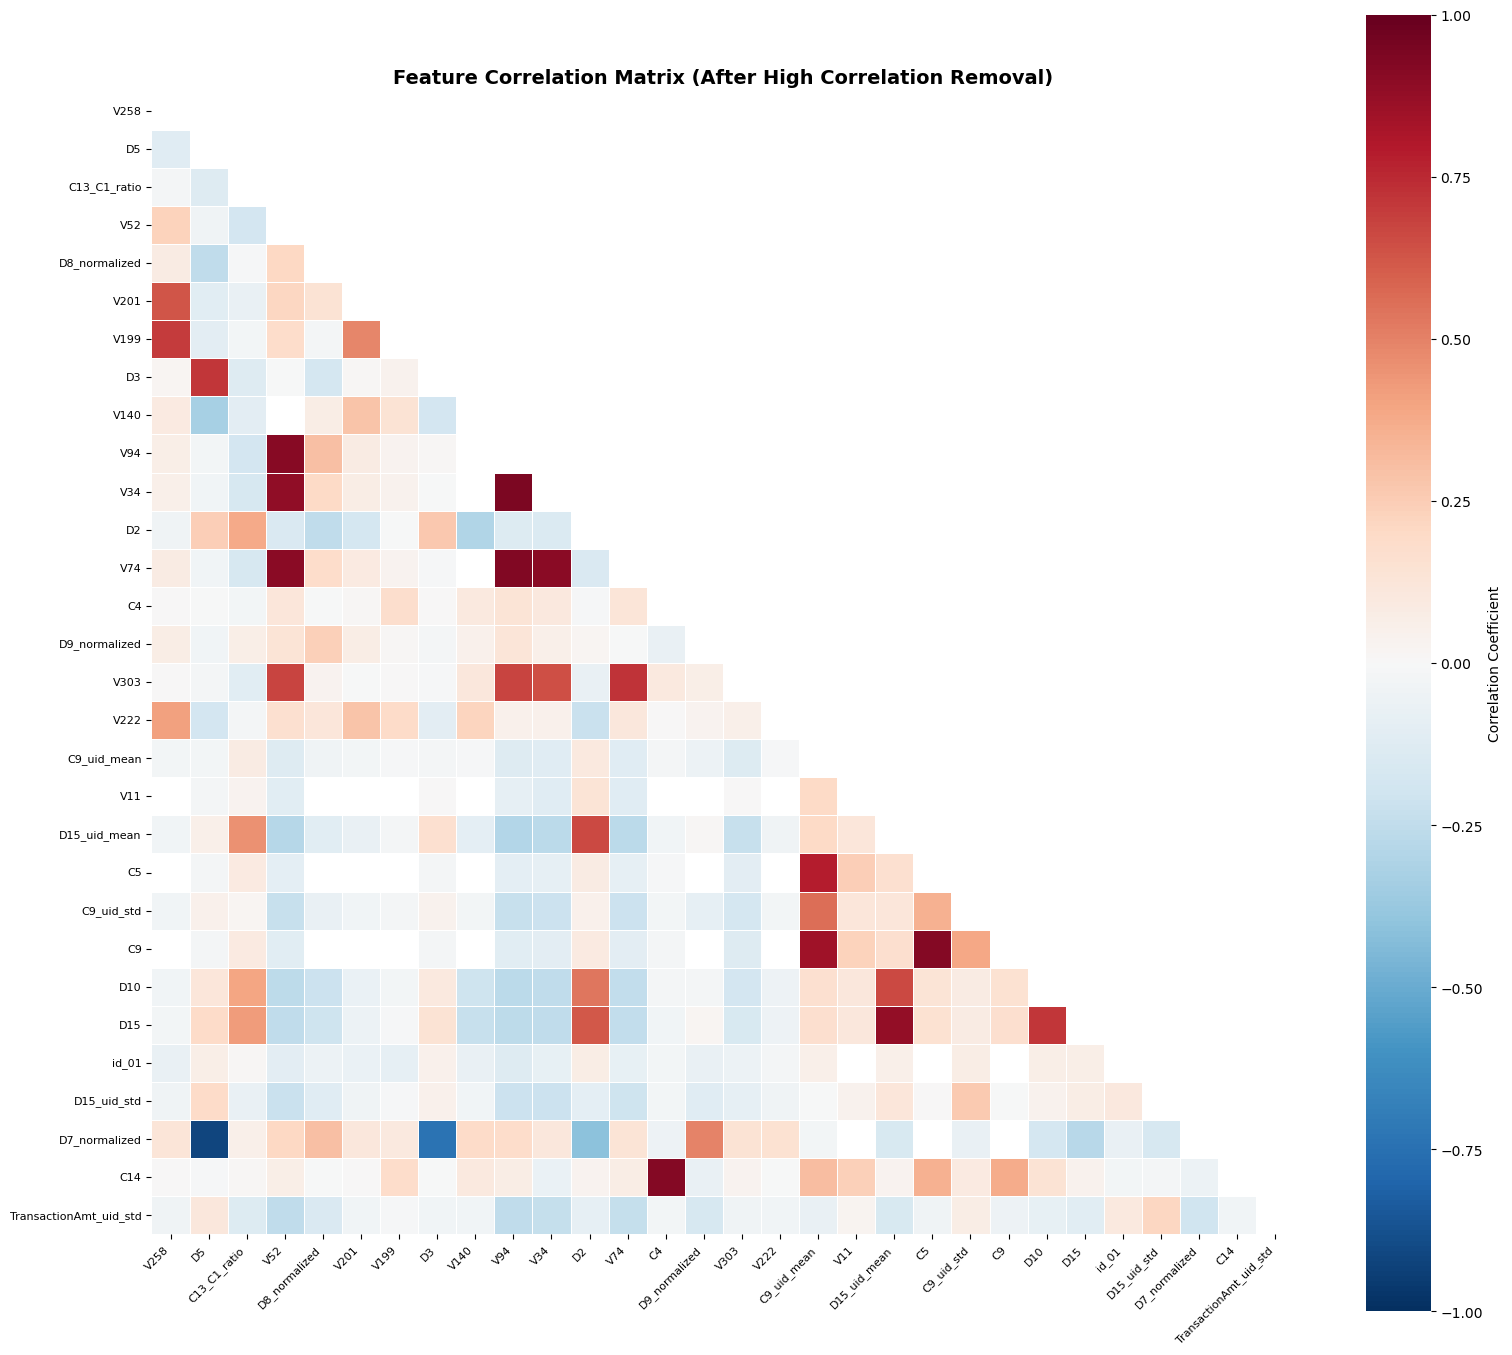


Remaining correlations > 0.8:
  D5 <-> D7_normalized: -0.919
  V52 <-> V94: 0.908
  V52 <-> V34: 0.883
  V52 <-> V74: 0.906
  V94 <-> V34: 0.941
  V94 <-> V74: 0.923
  V34 <-> V74: 0.902
  C4 <-> C14: 0.918
  C9_uid_mean <-> C9: 0.845
  D15_uid_mean <-> D15: 0.881


In [27]:
# Correlation heatmap for top features (limit to 30 for readability)
top_features_for_viz = filtered_features[:30] if len(filtered_features) > 30 else filtered_features

if len(top_features_for_viz) > 0:
    corr_matrix = train_df[top_features_for_viz].corr()
    
    plt.figure(figsize=(16, 14))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(
        corr_matrix, 
        mask=mask,
        annot=False,  # Too many features for annotations
        cmap='RdBu_r', 
        center=0,
        vmin=-1, 
        vmax=1,
        square=True,
        linewidths=0.5,
        cbar_kws={'label': 'Correlation Coefficient'}
    )
    
    plt.title('Feature Correlation Matrix (After High Correlation Removal)', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()
    
    # Print highly correlated pairs that remain (if any)
    print("\nRemaining correlations > 0.8:")
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.8:
                high_corr_pairs.append((
                    corr_matrix.columns[i], 
                    corr_matrix.columns[j], 
                    round(corr_matrix.iloc[i, j], 3)
                ))
    
    if high_corr_pairs:
        for pair in high_corr_pairs[:10]:
            print(f"  {pair[0]} <-> {pair[1]}: {pair[2]}")
    else:
        print("  None found - good separation achieved!")

### Outlier Analysis & Handling

Extreme outliers can negatively impact model training. We use **Winsorization** (percentile capping) to handle outliers while preserving the overall distribution shape.

**Method**: Cap values below the 1st percentile and above the 99th percentile.

**Reference**: Hastie, T., Tibshirani, R., & Friedman, J. (2009). "The Elements of Statistical Learning". Springer.

In [28]:
# Identify features with significant outliers
def detect_outlier_features(df, features, iqr_multiplier=3.0):
    """
    Detect features with extreme outliers using IQR method.
    
    Args:
        df: DataFrame
        features: List of numerical features to check
        iqr_multiplier: Multiplier for IQR to define outlier bounds (default 3.0)
    
    Returns:
        DataFrame with outlier statistics per feature
    """
    outlier_stats = []
    
    for col in features:
        if col not in df.columns:
            continue
        
        data = df[col].dropna()
        if len(data) == 0:
            continue
            
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        outlier_pct = len(outliers) / len(data) * 100
        
        if outlier_pct > 0.1:  # Only report if > 0.1% outliers
            outlier_stats.append({
                'Feature': col,
                'Outlier_Count': len(outliers),
                'Outlier_Pct': round(outlier_pct, 2),
                'Min': round(data.min(), 2),
                'Max': round(data.max(), 2),
                'Lower_Bound': round(lower_bound, 2),
                'Upper_Bound': round(upper_bound, 2)
            })
    
    return pd.DataFrame(outlier_stats).sort_values('Outlier_Pct', ascending=False)

# Detect outliers in filtered features
outlier_analysis = detect_outlier_features(train_df, filtered_features)
print(f"Features with significant outliers (> 0.1%):")
display(outlier_analysis.head(20))

Features with significant outliers (> 0.1%):


,Feature,Outlier_Count,Outlier_Pct,Min,Max,Lower_Bound,Upper_Bound
14,V222,48873,41.41,0.0,384.0,1.00,1.00
13,V303,117724,24.92,0.0,17.0,0.00,0.00
12,C4,114914,24.32,0.0,inf,0.00,0.00
33,D14,10872,21.82,-193.0,inf,-3.00,4.00
31,V324,14885,21.26,0.0,33.0,0.00,0.00
3,V52,56433,16.97,0.0,12.0,0.00,0.00
5,V201,18820,16.13,0.0,55.0,1.00,1.00
38,dist1,27089,14.62,0.0,inf,-63.00,91.00
11,V74,57531,14.19,0.0,8.0,0.00,0.00
9,V94,55211,13.99,0.0,2.0,0.00,0.00


In [29]:
# Apply outlier capping to features with significant outliers
# Using cap_outliers from numeric_functions.py

features_to_cap = outlier_analysis['Feature'].tolist() if len(outlier_analysis) > 0 else []

if features_to_cap:
    print(f"Applying Winsorization to {len(features_to_cap)} features...")
    
    # IMPORTANT: Learn bounds from train, apply same bounds to test
    # Store the bounds for reproducibility
    cap_bounds = {}
    for col in features_to_cap:
        if col in train_df.columns:
            cap_bounds[col] = {
                'lower': train_df[col].quantile(0.01),
                'upper': train_df[col].quantile(0.99)
            }
    
    # Apply to train
    train_df = cap_outliers(train_df, features_to_cap, lower_percentile=1, upper_percentile=99)
    
    # Apply SAME bounds to test (using train's percentiles)
    for col in features_to_cap:
        if col in test_df.columns and col in cap_bounds:
            test_df[col] = test_df[col].clip(cap_bounds[col]['lower'], cap_bounds[col]['upper'])
    
    print("Outlier capping completed!")
    print(f"\nSample bounds applied:")
    for col in list(cap_bounds.keys())[:5]:
        print(f"  {col}: [{cap_bounds[col]['lower']:.2f}, {cap_bounds[col]['upper']:.2f}]")
else:
    print("No features require outlier capping.")

Applying Winsorization to 40 features...
Outlier capping completed!

Sample bounds applied:
  V222: [0.00, 9.00]
  V303: [0.00, 2.00]
  C4: [0.00, 6.00]
  D14: [0.00, 549.00]
  V324: [0.00, 7.00]


## Data Preparation Summary

At this point, the following preprocessing steps have been completed:

1. **Missing Value Handling**: Dropped features with >95% missing values
2. **Categorical Engineering**: 
   - Rare category encoding for card3, card5
   - Email domain consolidation
   - Device info extraction
   - Screen feature extraction
   - Bivariate interaction features
3. **Encoding**: Label encoding (low cardinality) + Frequency encoding (high cardinality)
4. **Numerical Engineering**:
   - V-column reduction via missing pattern grouping + KS selection
   - Time features (TransactionDay, normalized D columns)
   - UID-based aggregations (train-safe)
   - Transaction amount features (log, decimal)
   - C-velocity ratios
5. **Feature Selection**: KS-test based classification (strong/moderate/weak)
6. **Correlation Removal**: Removed highly correlated features (r > 0.95), keeping higher KS
7. **Outlier Handling**: Winsorization (1st-99th percentile capping)

In [30]:
# Final dataset summary
print("=" * 60)
print("FINAL DATASET SUMMARY")
print("=" * 60)
print(f"\nTrain shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

print(f"\nFeature Type Tracking:")
print(f"  Total features: {train_df.shape[1]}")
print(f"  Tracked categorical features: {len(categorical_features)}")
print(f"  True numerical features: {len(numerical_features)}")
print(f"  Exclude columns (ID, target, uid): {len(exclude_cols)}")

print(f"\nNumerical Feature Selection (KS-based):")
print(f"  Filtered features for modeling: {len(filtered_features)}")
print(f"  Strong discrimination (KS >= 0.20): {len(strong_features)}")
print(f"  Moderate discrimination (0.10 <= KS < 0.20): {len(moderate_features)}")

print(f"\nTarget distribution (train):")
print(train_df['isFraud'].value_counts())
print(f"Fraud rate: {train_df['isFraud'].mean()*100:.2f}%")

print("\n" + "=" * 60)
print("Data preparation complete! Ready for model training.")
print("=" * 60)
print("\nNote: Categorical features were tracked throughout the notebook")
print("and properly excluded from numerical feature analysis.")

FINAL DATASET SUMMARY

Train shape: (472432, 160)
Test shape: (118108, 160)

Feature Type Tracking:
  Total features: 160
  Tracked categorical features: 62
  True numerical features: 94
  Exclude columns (ID, target, uid): 4

Numerical Feature Selection (KS-based):
  Filtered features for modeling: 51
  Strong discrimination (KS >= 0.20): 41
  Moderate discrimination (0.10 <= KS < 0.20): 35

Target distribution (train):
isFraud
0    455833
1     16599
Name: count, dtype: int64
Fraud rate: 3.51%

Data preparation complete! Ready for model training.

Note: Categorical features were tracked throughout the notebook
and properly excluded from numerical feature analysis.


In [36]:
# =============================================================================
# Save Preprocessed Data for Modeling
# =============================================================================
import pickle

# Save DataFrames as parquet (efficient for large data)
train_df.to_parquet(DATA / "train_preprocessed.parquet", index=False)
test_df.to_parquet(DATA / "test_preprocessed.parquet", index=False)

# Save feature lists
feature_lists = {
    'filtered_features': filtered_features,
    'categorical_features': categorical_features,
    'strong_features': strong_features,
    'moderate_features': moderate_features
}

with open(DATA / "feature_lists.pkl", 'wb') as f:
    pickle.dump(feature_lists, f)

print("✅ Data saved successfully!")
print(f"   - train_preprocessed.parquet: {train_df.shape}")
print(f"   - test_preprocessed.parquet: {test_df.shape}")
print(f"   - feature_lists.pkl: {len(filtered_features)} filtered features")

✅ Data saved successfully!
   - train_preprocessed.parquet: (472432, 160)
   - test_preprocessed.parquet: (118108, 160)
   - feature_lists.pkl: 51 filtered features
